##The Customer Lifetime Value (CLV) is a prediction of the total value generated by a customer in the future across the entire customer life cycle. CLV also commonly referred to as LTV, is a very important business metric that sits outside standard financial reporting. When calculated correctly, CLV is possibly the most commercially valuable insight at the disposal of the marketing team. The CLV model itself relies on a few different factors within predictive analytics techniques, with varying levels of sophistication and accuracy.
Before we go into modelling Customer Lifetime Value, we first need to know what it is trying to model. CLV is an attempt to take a customer's purchase history, predict a future stream of purchases, and then bring those future expected sales into a present value.
CLV prediction has become easier over the years as packages such as Lifetimes for python make it straightfoward calculation. However before we go about the calculations we need to ensure we have the right dataset to perform the calculations.

In [1]:
!pip install Lifetimes
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import datetime
from sklearn.metrics import mean_absolute_error, f1_score

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data

     |████████████████████████████████| 584 kB 6.1 MB/s eta 0:00:01


In [2]:
#Import 
df = pd.read_csv('../input/reduced2/reduced2.csv', parse_dates = ['date'])

In [9]:
##The dataset is sourced from kaggle's Acquired Value Shoppers challenge, which has over 22GB of customer transaction data across 350 million rows, 300,000 customers and over 1000 companies. However we will just take data for 1 company which has the most transactions for our CLV prediction

In [3]:
df.head()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,86246,205,99,9909,104538848,15343,2012-03-02,16.0,OZ,1,2.49
1,86246,205,58,5824,108674585,55172,2012-03-02,16.0,OZ,1,3.29
2,86246,205,72,7205,103500030,3830,2012-03-06,4.6,OZ,1,3.99
3,86246,205,55,5558,104154848,5603,2012-03-07,5.8,OZ,1,1.25
4,86246,205,58,5824,1076401474,304,2012-03-14,12.0,OZ,1,4.99


## Data Processing - We first check for a company with the highest purchases

In [4]:
df['company'].unique()

array([ 104538848,  108674585,  103500030, ..., 1079076777,  103262636,
       1085522282])

In [5]:
# Checking highest category
df['company'].value_counts()

107143070     1148035
101111010     1091179
103700030      974087
107127979      969615
103500030      872567
               ...   
1085894989          1
108800484           1
1087900181          1
1085460484          1
103342131           1
Name: company, Length: 1572, dtype: int64

In [6]:
df['company']=df.company.astype('str')
# df.info()

<b>As company 107143070 has maximum no values so ultimately, it's purchase amount is highest. So I will keep only the rows which belongs to this company 


In [7]:
df = df[df.company == '107143070']
# df = df.company[df.company=='107143070']


## Dataset w.r.t 1-Compay

In [8]:
# Datafrane with respect to one company = '107143070'
df

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
6,86246,205,99,9909,107143070,5072,2012-03-18,22.0,OZ,1,2.59
11,86246,205,99,9909,107143070,5072,2012-03-21,22.0,OZ,1,2.59
406,86246,205,99,9909,107143070,5072,2013-04-10,9.0,OZ,2,3.98
426,86246,205,99,9909,107143070,5072,2013-04-13,9.0,OZ,2,3.98
429,86246,205,99,9909,107143070,5072,2013-04-14,9.0,OZ,2,3.98
...,...,...,...,...,...,...,...,...,...,...,...
15349921,4847628950,166,99,9909,107143070,5072,2013-07-22,9.9,OZ,2,5.98
15349940,4847628950,166,99,9909,107143070,5072,2013-07-23,8.0,OZ,1,1.49
15349941,4847628950,166,99,9909,107143070,5072,2013-07-23,5.0,OZ,1,2.99
15349942,4847628950,166,99,9909,107143070,5072,2013-07-23,9.0,OZ,3,4.50


## Data Preprocessing - 

In [9]:
#Select 1 year of data with positive sales (no refunds)
df_year = df.loc[(df.date <= '2013-03-02') & (df.purchaseamount > 0), ['id', 'date', 'purchasequantity', 'purchaseamount']]

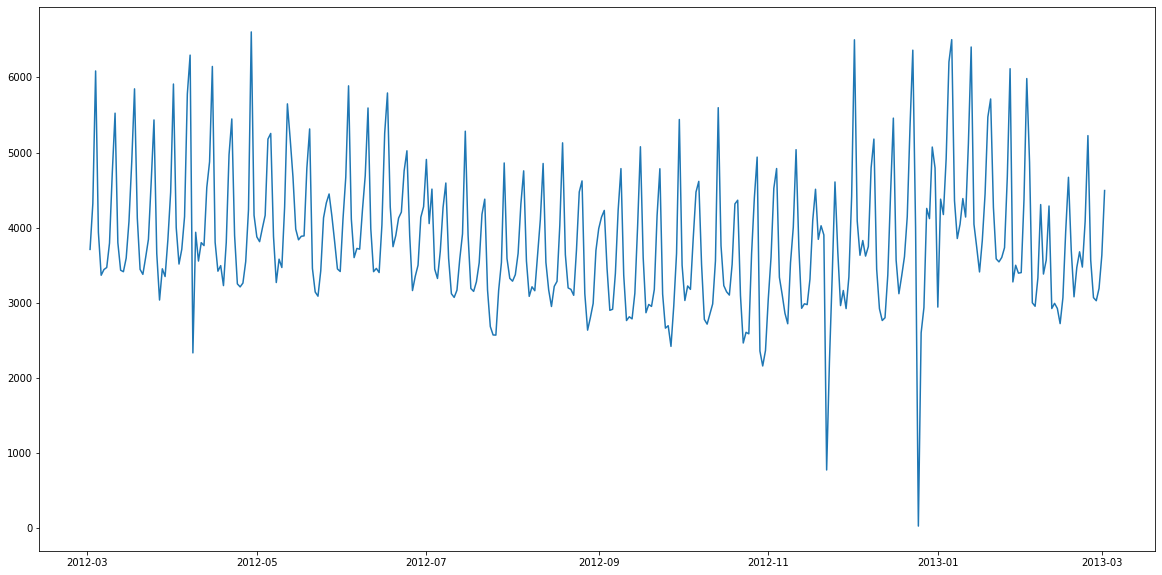

In [10]:
sales = df_year.groupby('date')['purchasequantity'].sum()
plt.figure(figsize=(20, 10))
plt.plot(sales)

In [11]:
print(f'Unique Customers: {df_year["id"].nunique()}')
#print(f'Unique Customers: {df_year["company"].nunique()}')
print(f'Unique Days: {df_year["date"].nunique()}')

Unique Customers: 121817
Unique Days: 366


My goal is to model the lifetime value of the customers. Some customers are going to have a lot of purchases with the company whereas others might have already churned.

In [12]:
df_year.id.value_counts().describe()

count    121817.000000
mean          7.780195
std          34.477059
min           1.000000
25%           2.000000
50%           4.000000
75%           9.000000
max        6010.000000
Name: id, dtype: float64

In [13]:
#df_year.head() #2012-03-02 #2013-02-14
df_year.tail()

,id,date,purchasequantity,purchaseamount
15348830,4797277036,2012-05-06,1,3.69
15348832,4797277036,2012-06-05,1,3.69
15348838,4797277036,2012-07-30,1,3.69
15348844,4797277036,2012-10-07,1,3.69
15348849,4797277036,2012-11-24,1,3.69


There are a variety of CLV models, including popular the BG/NBD model. 

The first major component of this model is to predict average monthly spending (or profit) while a customer is alive. This is shown below as a uniform manner with the average spending calculated from the above purchase history.

## Modelling and Evaluation

The modelling & evaluation process is going to be the following:
1. Split into train and test periods
2. Fit and evaluate BG/NBD model for frequency prediction
3. Fit and evaluate Gamma-Gamma model for monetary value prediction
4. Combine 2 models into CLV model and compare to baseline
5. Refit the model on the entire dataset

### 1. Train Test Split
The utility function in `lifetimes` package allows to split and test, so splitting the data is quite easy. 

In [14]:
#Split
rfm_train_test = calibration_and_holdout_data(df_year, 'id', 'date',
                                        calibration_period_end='2012-11-01',
                                        observation_period_end='2013-03-02',
                                                  monetary_value_col = 'purchaseamount')   

In [15]:
rfm_train_test.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
id,,,,,,,
86246,1.0,3.0,228.0,2.590000,0.0,0.000000,121.0
86252,1.0,1.0,241.0,2.590000,0.0,0.000000,121.0
42937475,0.0,0.0,219.0,0.000000,4.0,3.565000,121.0
44975538,0.0,0.0,7.0,0.000000,2.0,3.490000,121.0
122477854,13.0,218.0,230.0,3.817692,3.0,4.453333,121.0


## Expanding RFM to Calculate Customer Segments

RFM (recency, frequency, monetary) analysis is a behavior based technique used to segment customers by examining their transaction history such as

how recently a customer has purchased (recency)
how often they purchase (frequency)
how much the customer spends (monetary)
It is based on the marketing axiom that 80% of your business comes from 20% of your customers. RFM helps to identify customers who are more likely to respond to promotions by segmenting them into various categories.



In [16]:
rfm = rfm_train_test.copy()
rfm = rfm.reset_index()


In [17]:
rfm.head()

,id,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
0,86246,1.0,3.0,228.0,2.590000,0.0,0.000000,121.0
1,86252,1.0,1.0,241.0,2.590000,0.0,0.000000,121.0
2,42937475,0.0,0.0,219.0,0.000000,4.0,3.565000,121.0
3,44975538,0.0,0.0,7.0,0.000000,2.0,3.490000,121.0
4,122477854,13.0,218.0,230.0,3.817692,3.0,4.453333,121.0


In [18]:
rfm = rfm[['id','recency_cal','frequency_cal','monetary_value_cal']]
rfm = rfm.set_axis(['CustmerID', 'Recency', 'Frequency', 'Monetary'], axis=1, inplace=False)
rfm.head()

,CustmerID,Recency,Frequency,Monetary
0,86246,3.0,1.0,2.590000
1,86252,1.0,1.0,2.590000
2,42937475,0.0,0.0,0.000000
3,44975538,0.0,0.0,0.000000
4,122477854,218.0,13.0,3.817692


In [19]:
rfm = rfm.set_index('CustmerID')
rfm.head()

,Recency,Frequency,Monetary
CustmerID,,,
86246,3.0,1.0,2.590000
86252,1.0,1.0,2.590000
42937475,0.0,0.0,0.000000
44975538,0.0,0.0,0.000000
122477854,218.0,13.0,3.817692


In [20]:
# Print top 5 rows and shape of dataframe
print(rfm.head())
print('{:,} rows; {:,} columns'
      .format(rfm.shape[0], rfm.shape[1]))

           Recency  Frequency  Monetary
CustmerID                              
86246          3.0        1.0  2.590000
86252          1.0        1.0  2.590000
42937475       0.0        0.0  0.000000
44975538       0.0        0.0  0.000000
122477854    218.0       13.0  3.817692
105,493 rows; 3 columns


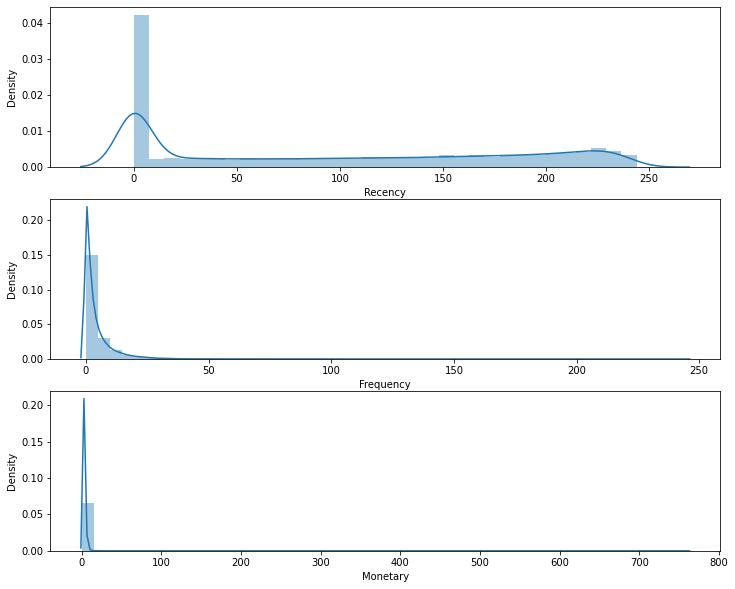

In [21]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm['Monetary'])
# Show the plot
plt.show()

In [22]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 0.0, 0.4: 44.0, 0.6: 127.0, 0.8: 195.0},
 'Frequency': {0.2: 0.0, 0.4: 1.0, 0.6: 3.0, 0.8: 6.0},
 'Monetary': {0.2: 0.0, 0.4: 1.99, 0.6: 2.99, 0.8: 3.995}}

In [23]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5    

In [24]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [25]:
rfm['RFM_Segment_Concat'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment_Concat
CustmerID,,,,,,,
86246,3.0,1.0,2.590000,4,2,3,423
86252,1.0,1.0,2.590000,4,2,3,423
42937475,0.0,0.0,0.000000,5,1,1,511
44975538,0.0,0.0,0.000000,5,1,1,511
122477854,218.0,13.0,3.817692,1,5,4,154


In [26]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())

64


In [27]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

CustmerID
86246         9
86252         9
42937475      7
44975538      7
122477854    10
Name: RFM_Score, dtype: int64


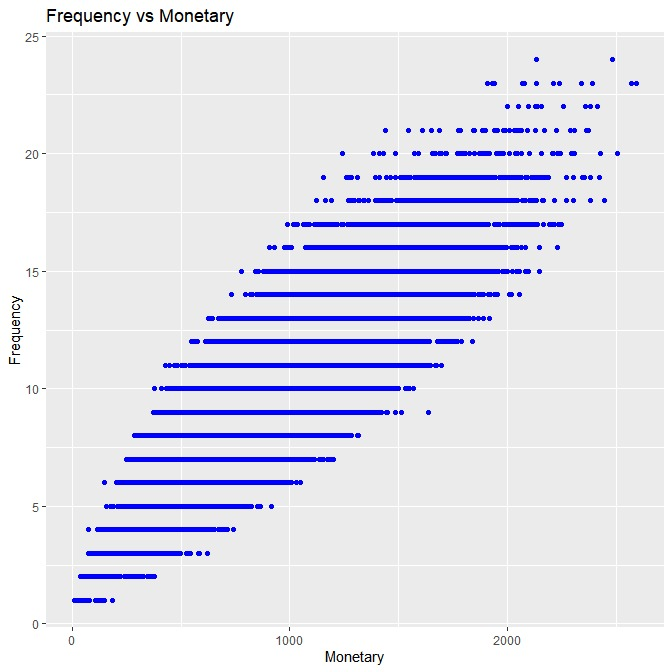

In [29]:
from IPython.display import Image
Image("../input/graph-image/cell 2.jpg")

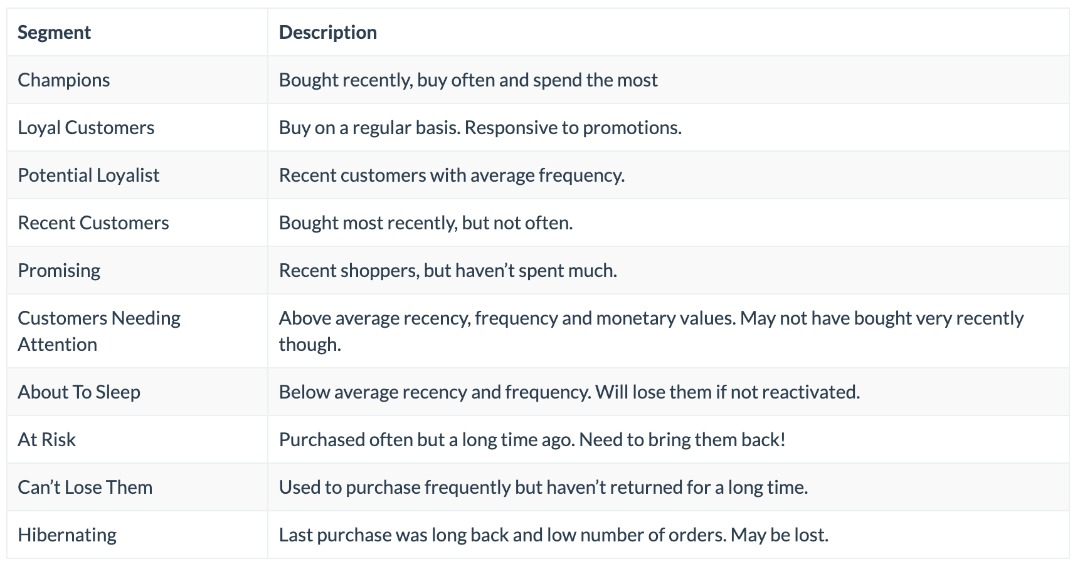

In [28]:
from IPython.display import Image
Image("../input/table-image/cell 1.jpg")

In [30]:
# rfm[rfm['Frequency']<50 ].plot.scatter(x='Monetary', y='Frequency') 

In [31]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9.5:
        return 'Champions' # 
    elif ((df['RFM_Score'] >= 9.0) and (df['RFM_Score'] < 9.5)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 8.5) and (df['RFM_Score'] < 9.0)):
        return 'Potential Loyalists'
    elif ((df['RFM_Score'] >= 8.0) and (df['RFM_Score'] < 8.5)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 7.5) and (df['RFM_Score'] < 8.0)):
        return 'Needs Attension'
    elif ((df['RFM_Score'] >= 7.0) and (df['RFM_Score'] < 8.0)):
        return 'Hibernating'
    elif ((df['RFM_Score'] >= 6.5) and (df['RFM_Score'] < 7.0)):
        return 'At Risk'
    elif ((df['RFM_Score'] >= 6.0) and (df['RFM_Score'] < 6.5)):
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 5.5) and (df['RFM_Score'] < 6.)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
CustmerID,,,,,,,,,
86246,3.0,1.0,2.590000,4,2,3,423,9,Loyal
86252,1.0,1.0,2.590000,4,2,3,423,9,Loyal
42937475,0.0,0.0,0.000000,5,1,1,511,7,Hibernating
44975538,0.0,0.0,0.000000,5,1,1,511,7,Hibernating
122477854,218.0,13.0,3.817692,1,5,4,154,10,Champions


In [1]:
## Expanding RFM to Calculate Customer Segments
#RFM (recency, frequency, monetary) analysis is a behavior based technique used to segment customers by examining their transaction history such as
#how recently a customer has purchased (recency)
#how often they purchase (frequency)
#how much the customer spends (monetary)
#It is based on the marketing axiom that 80% of your business comes from 20% of your customers. RFM helps to identify customers who are more likely to respond to promotions by segmenting them into various categories.

In [32]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency Monetary       
                      mean      mean     mean  count
RFM_Level                                           
Can't Loose Them     182.2       1.4      1.8   1119
Champions            139.6       7.6      4.5  37274
Hibernating           19.4       0.3      0.3  36635
Loyal                135.6       5.0      2.9  18107
Promising            126.1       2.9      2.3  12207
Require Activation   213.0       1.0      1.6    151


In [2]:
import squarify

#rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(26, 18)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions','At Risk','About To Sleep','Hibernating',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=42,fontweight="bold")
plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'squarify'

- 1. Potential — high potential to enter our loyal customer segments, why not throw in some freebies on their next purchase to show that you value them!
Promising — showing promising signs with quantity and value of their purchase but it has been a while since they last bought sometime from you. Let’s target them with their wishlist items and a limited time offer discount.
- 2. Needs Attention — made some initial purchase but have not seen them since. Was it a bad customer experience? Or product-market fit? Let’s spend some resource build our brand awareness with them.
- 3. Require Activation — Poorest performers of our RFM model. They might have went with our competitors for now and will require a different activation strategy to win them back.

Before going into modelling, let's filter out those customers who have not made a repeat purchase. For these customers we can't really make a prediction, so they are irrelevant for the model. 

In [34]:
rfm_train_test = rfm_train_test.loc[rfm_train_test.frequency_cal > 0, :]

### 2. Beta Geo Model

This model is an industry standard when it comes to CLV modelling. It stands for Beta Geometric/Negative Binomal Distribution and was intrudced by [Fader et al. (2005)](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf). Its basic idea is that sales of each customer can be described as a combination of his/her proability to buy and to churn. As such, it models the sales for a particular customer as a function of 2 distributions - Gamma for transactions and probability of churn as Beta. The model that we're about to fit learns 4 parameters that are able to describe these distributions. In this way, we get a unique transaction and churn probability for each customer (as we want) without having a model with hunders of parameters. 


#### Model Fit

In [35]:
%%time
#Train the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(rfm_train_test['frequency_cal'], rfm_train_test['recency_cal'], rfm_train_test['T_cal'])

CPU times: user 1.49 s, sys: 4.04 ms, total: 1.49 s
Wall time: 1.49 s


<lifetimes.BetaGeoFitter: fitted with 73881 subjects, a: 0.10, alpha: 59.00, b: 0.81, r: 1.96>

In [36]:
#Predict
predicted_bgf = bgf.predict((datetime.datetime(2013, 3, 2)- datetime.datetime(2012, 11, 1)).days,
                        rfm_train_test['frequency_cal'], 
                        rfm_train_test['recency_cal'], 
                        rfm_train_test['T_cal'])

#### Model Evaluation

In [37]:
actual = rfm_train_test['frequency_holdout']
predicted = predicted_bgf

def evaluate_clv(actual, predicted, bins):
    print(f"Average absolute error: {mean_absolute_error(actual, predicted)}")
    #Evaluate numeric
    plt.figure(figsize=(10, 7))
    plt.scatter(predicted, actual)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Predicted vs Actual')
    plt.show()
    
    #Evaluate Bins
    est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
    est.fit(np.array(actual).reshape(-1, 1))
    actual_bin = est.transform(np.array(actual).reshape(-1, 1)).ravel()
    predicted_bin = est.transform(np.array(predicted).reshape(-1, 1)).ravel()
    
    cm = confusion_matrix(actual_bin, predicted_bin, normalize='true')
    df_cm = pd.DataFrame(cm, index = range(1, bins+1),
                      columns = range(1, bins+1))
    plt.figure(figsize = (20,10))
    sns.heatmap(df_cm, annot=True)

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()
    print(f'F1 score: {f1_score(actual_bin, predicted_bin, average="macro")}')
    print('Samples in each bin: \n')
    print(pd.Series(actual_bin).value_counts())


Average absolute error: 1.753989845389625


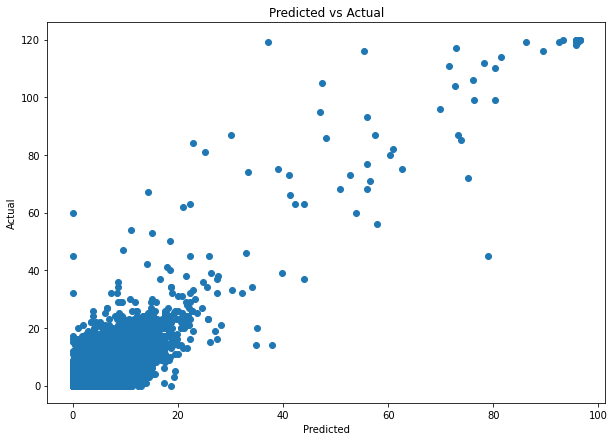

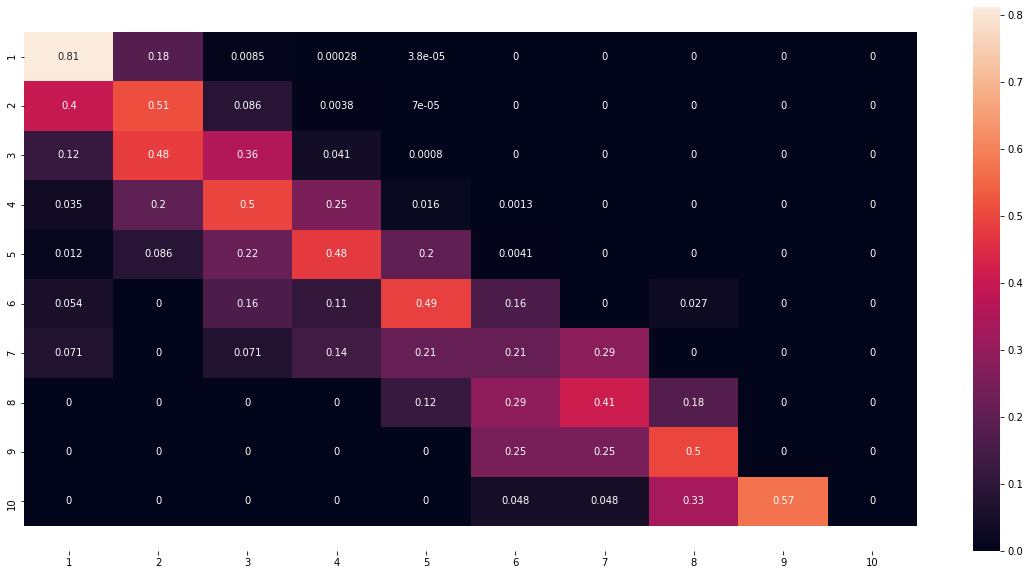

F1 score: 0.2958554119646325
Samples in each bin: 

0.0    52761
1.0    14225
2.0     4970
3.0     1585
4.0      243
5.0       37
9.0       21
7.0       17
6.0       14
8.0        8
dtype: int64


In [38]:
evaluate_clv(actual, predicted, bins=10)

Model does a pretty good job overall with average aboslute error of about 3 purchases. Furthermore, it predict larger number of purchases for those that actually do purchase more. Let's see how the second model performs with predicting the monetary value.

### 3. Gamma-Gamma Model

Gamma-Gamma model presented in the same paper, adds a monetary value into the mix. It does so by assuming that the spend of an individual is right-skewed and follows a Gamma distribution. One of the parameters required to describe Gamma distribution, also varies per customer (so each customer again ends up with different propensity to spend) and it also follows a Gamma distribution. That's why the model is called Gamma-Gamma. 

#### Model Fit

To ensure that we can use Gamma Gamma, we need to check if frequency and monetary values are not correlated. 

In [39]:
rfm_train_test[['monetary_value_cal', 'frequency_cal']].corr()

,monetary_value_cal,frequency_cal
monetary_value_cal,1.000000,0.260283
frequency_cal,0.260283,1.000000


Seems like the correlation is quite low, so we can continue.

In [40]:

ggf = GammaGammaFitter(penalizer_coef = 0.0)
ggf.fit(rfm_train_test['frequency_cal'],
        rfm_train_test['monetary_value_cal'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 73881 subjects, p: 7.92, q: 7.88, v: 3.11>


#### Model Evaluation

In [41]:
monetary_pred = ggf.conditional_expected_average_profit(rfm_train_test['frequency_holdout'],
                                        rfm_train_test['monetary_value_holdout'])

Average absolute error: 1.1935034231248818


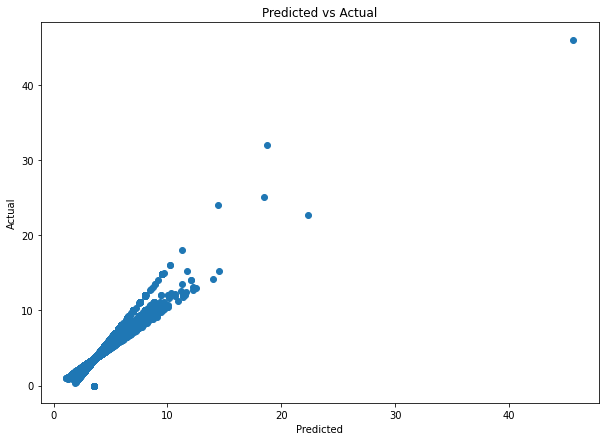

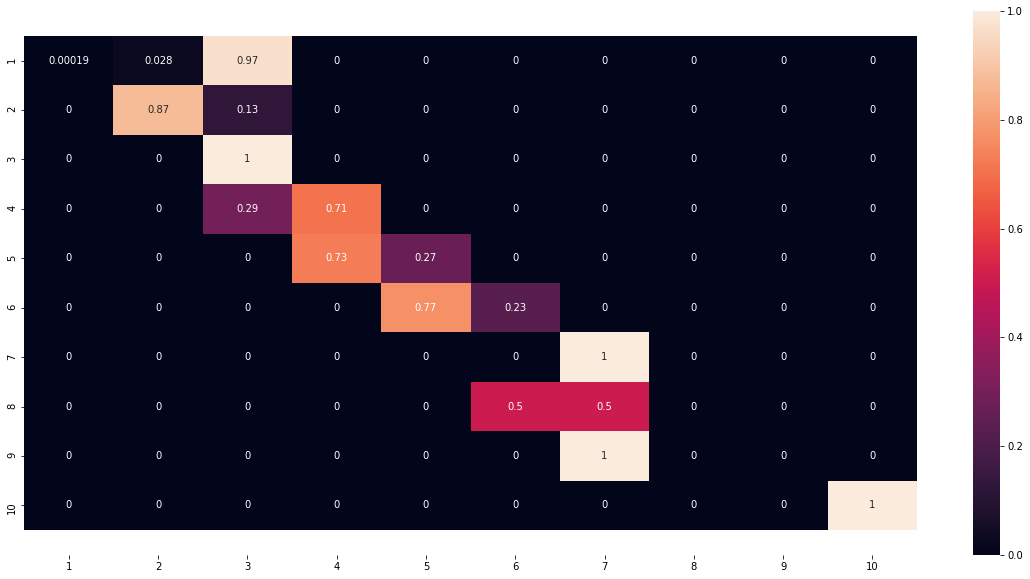

F1 score: 0.4612909465424641
Samples in each bin: 

1.0    28268
2.0    20902
0.0    20704
3.0     3676
4.0      291
5.0       35
7.0        2
6.0        1
9.0        1
8.0        1
dtype: int64


In [42]:
evaluate_clv(rfm_train_test['monetary_value_holdout'], monetary_pred, bins=10)

By the looks of it, Gamma Gamma models the monetary value quite well, with larger values being placed to the higher bins. The F1 score is not that great, but it's also not completely random. Since both models are valid, we can combine them into a single life-time value model.

### 4. Combined CLV Model

Once we've proven that both models has a predictive power, we can combine them into 1 model that will model the expected Customer Lifetime Value. 

In [43]:
bgf.fit(rfm_train_test['frequency_cal'], rfm_train_test['recency_cal'], rfm_train_test['T_cal'])


clv = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    rfm_train_test['frequency_cal'],
    rfm_train_test['recency_cal'],
    rfm_train_test['T_cal'],
    rfm_train_test['monetary_value_cal'],
    time=4, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

rfm_train_test['clv'] = clv

In [44]:
rfm_train_test.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,clv
id,,,,,,,,
86246,1.0,3.0,228.0,2.590000,0.0,0.000000,121.0,0.287695
86252,1.0,1.0,241.0,2.590000,0.0,0.000000,121.0,0.223082
122477854,13.0,218.0,230.0,3.817692,3.0,4.453333,121.0,22.249539
122671177,1.0,8.0,60.0,2.790000,1.0,2.990000,121.0,5.142793
122702502,6.0,168.0,187.0,2.158333,4.0,1.930000,121.0,8.356184


In [45]:
rfm_train_test= rfm_train_test.reset_index('id')

In [46]:
rfm_train_test.head()

,id,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,clv
0,86246,1.0,3.0,228.0,2.590000,0.0,0.000000,121.0,0.287695
1,86252,1.0,1.0,241.0,2.590000,0.0,0.000000,121.0,0.223082
2,122477854,13.0,218.0,230.0,3.817692,3.0,4.453333,121.0,22.249539
3,122671177,1.0,8.0,60.0,2.790000,1.0,2.990000,121.0,5.142793
4,122702502,6.0,168.0,187.0,2.158333,4.0,1.930000,121.0,8.356184


We're going to compare now the model to a simple approach of ranking the users according to their historic average.

#### Comparing to baseline
Let's imagine a scenario - we need to pick top 20% of our best users to target. Those who are not targeted will not purchase anything, so we need to be careful in the selection process. One way to do it, would be to select those users who have previously purchased a lot. I'll call this method a naive approach and I'll compare it to the model approach. Becuase we need to pick the ranking variable, I'll start with top 20% of users according to their Frequency and will compare them to top 20% according to calculated CLV.

In [47]:
top_20_len = int(rfm_train_test.shape[0]*0.2)

#Naive approach by averaging the historic frequency
naive_top20_index_freq = rfm_train_test.sort_values(['frequency_cal'], ascending=False).index.values[:top_20_len]
naive_top20_id_freq = rfm_train_test.loc[naive_top20_index_freq , 'id'].unique()

#Model approach IDs
clv_top20 = rfm_train_test.sort_values('clv', ascending = False)['id'].values[:top_20_len]

#Check if the number of customers selected is the same
assert len(naive_top20_id_freq) == len(clv_top20)

#Transactions dataframe with holdout dates
df_test = df_year.loc[df_year.date > '2012-11-01', :]

#Include only those users who were selected
df_test_naive_freq = df_test[df_test['id'].isin(naive_top20_id_freq)]
df_test_clv = df_test[df_test['id'].isin(clv_top20)]

print(f"Additional transactions with model approach: {df_test_clv.groupby('date')['purchasequantity'].count().sum() - df_test_naive_freq.groupby('date')['purchasequantity'].count().sum() }")

Additional transactions with model approach: -1301


### Revenue

Let's now see if the gains also generalise to the generated revenue.

In [48]:
naive_top20_index_mon = rfm_train_test.sort_values(['monetary_value_cal'], ascending=False).index.values[:top_20_len]
naive_top20_id_mon = rfm_train_test.loc[naive_top20_index_mon , 'id'].unique()
df_test_naive_mon = df_test[df_test['id'].isin(naive_top20_id_mon)]

print(f"Additional revenue with model approach: {df_test_clv.groupby('date')['purchaseamount'].sum().sum() - df_test_naive_mon.groupby('date')['purchaseamount'].sum().sum() }")

Additional revenue with model approach: 129016.89999999473


We can visualise this additional revenue by plotting the cumulative total sales of these users who were selected.

In [49]:
revenue_cdf_clv = []
for idx in tqdm(clv_top20):
    rev = df_test_clv.loc[df_test_clv.id == idx, 'purchaseamount'].sum()
    revenue_cdf_clv.append(rev)
    
cumsum_clv = np.cumsum(revenue_cdf_clv)

100%|██████████| 14776/14776 [00:11<00:00, 1303.90it/s]


In [50]:
monetary_cdf_naive = []
for idx in tqdm(naive_top20_id_mon):
    rev = df_test_naive_mon.loc[df_test_naive_mon.id == idx, 'purchaseamount'].sum()
    monetary_cdf_naive.append(rev)
    
cumsum_mon = np.cumsum(monetary_cdf_naive)

100%|██████████| 14776/14776 [00:10<00:00, 1395.95it/s]


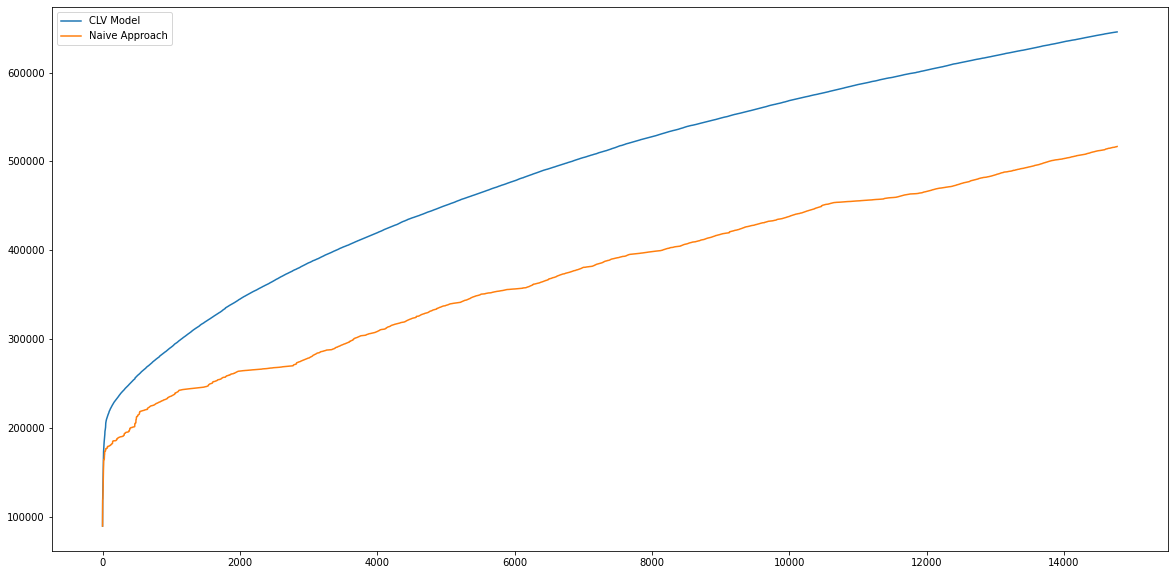

In [51]:
plt.figure(figsize=(20, 10))
plt.plot(cumsum_clv, label='CLV Model')
plt.plot(cumsum_mon, label='Naive Approach')
plt.legend()

## Model Re-Train

Now that we've established that the model approach works, we can re-train the model on the entire dataset. Let's find out who are the top 10 most valuable customers.

In [52]:
rfm = summary_data_from_transaction_data(df_year, 'id', 'date', monetary_value_col = 'purchaseamount')
rfm = rfm.loc[rfm.frequency > 0, :]

In [53]:
#BG/NBD
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'])

<lifetimes.BetaGeoFitter: fitted with 92177 subjects, a: 0.07, alpha: 58.47, b: 0.89, r: 1.61>

In [54]:
#GG
ggf = GammaGammaFitter(penalizer_coef = 0.0)
ggf.fit(rfm['frequency'],
        rfm['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 92177 subjects, p: 8.24, q: 8.35, v: 3.18>


In [55]:
#CLV model
clv = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    rfm['frequency'],
    rfm['recency'],
    rfm['T'],
    rfm['monetary_value'],
    time=4, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

rfm['clv'] = clv

**These are the top 10 most valuable customers** and how much they are worth in the next 4 months

In [56]:
rfm.sort_values('clv', ascending=False).head(10)

,frequency,recency,T,monetary_value,clv
id,,,,,
378964359,364.0,365.0,365.0,756.135440,75487.432662
618764932,364.0,365.0,365.0,245.849231,24544.507323
3594433805,363.0,365.0,365.0,52.174821,5195.306343
520773287,356.0,365.0,365.0,48.313174,4718.253790
2516399020,299.0,362.0,362.0,56.818328,4694.968236
347580535,364.0,365.0,365.0,44.571951,4450.581048
3430034260,362.0,365.0,365.0,43.994061,4368.798849
360871647,362.0,365.0,365.0,43.527541,4322.480718
3288731255,334.0,361.0,361.0,46.031587,4258.074550


In [ ]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])


#order the cluster numbers
tx_user1 = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

#show details of the dataframe
tx_user1.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,530.0,11.415151,9.049106,0.99,3.5425,8.345,18.3150,35.29
1,156.0,58.210577,19.894029,35.53,42.9625,51.810,69.4900,114.39
2,32.0,170.649687,42.102574,119.86,139.5525,160.405,199.2925,274.65
3,18.0,405.791111,93.013444,302.25,351.0075,390.175,450.6525,640.08
4,4.0,1000.960000,213.212378,740.66,896.2700,1006.990,1111.6800,1249.20
5,2.0,1658.025000,278.465721,1461.12,1559.5725,1658.025,1756.4775,1854.93
6,1.0,41358.130000,NaN,41358.13,41358.1300,41358.130,41358.1300,41358.13


In [ ]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order the frequency cluster
tx_user1 = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#see details of each cluster
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,192.0,8.869792,2.668161,6.0,7.0,8.0,10.00,16.0
1,1.0,355.000000,NaN,355.0,355.0,355.0,355.00,355.0
2,20.0,49.850000,7.198501,38.0,43.0,49.5,55.25,62.0
3,51.0,24.725490,5.488455,17.0,20.5,23.0,28.50,37.0
4,1.0,161.000000,NaN,161.0,161.0,161.0,161.00,161.0
5,473.0,2.234672,1.331616,1.0,1.0,2.0,3.00,5.0
6,5.0,92.000000,9.565563,84.0,86.0,89.0,93.00,108.0


In [ ]:
def rfm_level(tx_user1):
    if tx_user1['OverallScore'] >= 7:
        return 'Can\'t Loose Them'
    elif ((tx_user1['OverallScore'] >= 6) and (tx_user1['OverallScore'] < 9)):
        return 'Champions'
    elif ((tx_user1['OverallScore'] >= 5) and (tx_user1['OverallScore'] < 8)):
        return 'Loyal'
    elif ((tx_user1['OverallScore'] >= 4) and (tx_user1['OverallScore'] < 7)):
        return 'Potential'
    elif ((tx_user1['OverallScore'] >= 3) and (tx_user1['OverallScore'] < 6)):
        return 'Promising'
    elif ((tx_user1['OverallScore'] >= 2) and (tx_user1['OverallScore'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
tx_user1['RFM_Level'] = tx_user1.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
tx_user1.head()

,CustomerID,Recency,RecencyCluster,Frequency,Revenue,RevenueCluster,OverallScore,Segment,FrequencyCluster,RFM_Level
0,4641896467,348,4,4,10.66,2,0,Low-Value,0,Require Activation
1,4641907944,312,4,1,3.69,2,0,Low-Value,0,Require Activation
2,4641911091,329,4,1,7.96,2,0,Low-Value,0,Require Activation
3,4641911875,498,2,2,7.98,2,0,Low-Value,0,Require Activation
4,4641920873,494,2,1,14.76,2,0,Low-Value,0,Require Activation


In [ ]:
rfm_level_agg = tx_user1.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Revenue': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency  Revenue      
                      mean      mean     mean count
RFM_Level                                          
Can't Loose Them      38.8     179.2  11155.3     4
Champions             14.0      64.7   1318.7     3
Loyal                 50.1      52.9    344.3     9
Needs Attention      131.9       5.6     27.7   249
Potential             71.1      35.1    248.2    33
Promising             46.1       5.3     23.3   270
Require Activation   280.2       3.6     20.1   175


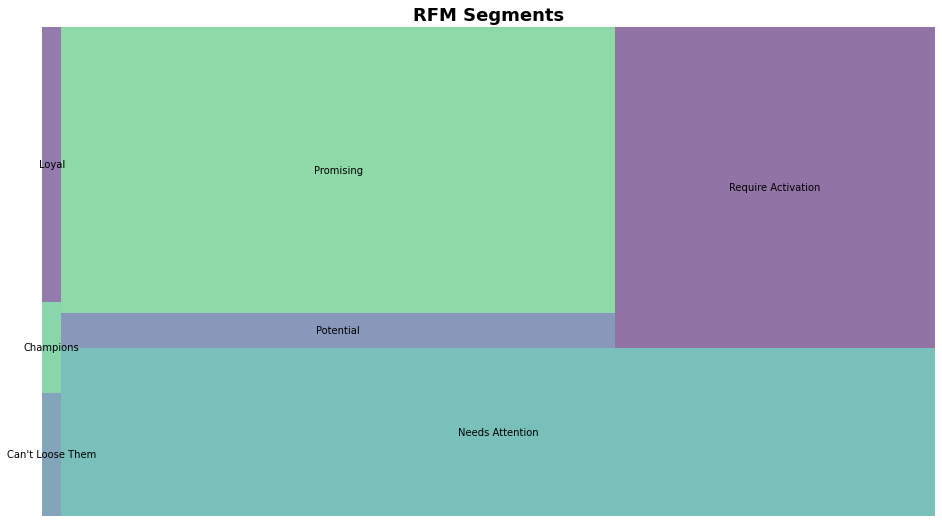

In [ ]:
!pip3 install squarify
import squarify

rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.xlabel('Xlabel')
plt.xlabel('Ylabel')
plt.axis('off')
plt.show()
